# <center>Supplementary Information for</center>
## <center>__Machine Learning of Nonadiabatic Coupling Vectors is Easier Than Energies__</center>
### <center>Jakub Martinka<sup>1,2</sup>, Lina Zhang<sup>3</sup>, Yi-Fan Hou<sup>3</sup>, Mikolaj Martyka<sup>4</sup>, Jiří Pittner<sup>\*,1</sup>, Mario Barbatti<sup>\*,5,6</sup> and Pavlo O. Dral<sup>*,3,7,8</sup>

$^1$ J. Heyrovský Institute of Physical Chemistry, Academy of Sciences of the Czech Republic, v.v.i., Dolejškova 3, 18223 Prague 8, Czech Republic<br>
$^2$ Department of Physical and Macromolecular Chemistry, Faculty of Sciences, Charles University, Hlavova 8, 128 43 Prague 2, Czech Republic<br>
$^3$ State Key Laboratory of Physical Chemistry of Solid Surfaces, College of Chemistry and Chemical Engineering, and Fujian Provincial Key Laboratory of Theoretical and Computational Chemistry, Xiamen University, Xiamen, Fujian 361005, China<br>
$^4$ Faculty of Chemistry, University of Warsaw, Pasteura 1, Warsaw, 02-093, Poland<br>
$^5$ Aix Marseille University, CNRS, ICR, Marseille, France<br>
$^6$ Institut Universitaire de France, 75231 Paris, France<br>
$^7$ Institute of Physics, Faculty of Physics, Astronomy,and Informatics, Nicolaus Copernicus University in Toruń, ul. Grudziądzka 5, 87-100 Toruń, Poland<br>
$^8$ Aitomistic, Shenzhen, China<br>
$^*$ Corresponding authors: jiri.pittner@jh-inst.cas.cz, mario.barbatti@univ-amu.fr, dral@xmu.edu.cn
___

Data used within this Jupyter Notebook are available from: https://github.com/JakubMartinka/Fulvene-ML-FSSH

Training and test sets, as well as models, are saved on FigShare: https://doi.org/10.6084/m9.figshare.28877672

Trajectories in H5MD format (exceeding 10 GB) can be provided upon request due to their size.


In [1]:
import numpy as np
import pandas as pd
import mlatom as ml
import csv

from prettytable import PrettyTable
import matplotlib.pyplot as plt

# Colors:
cg = '#1b9e77'
co = '#d95f02'
cp = '#7570b3'
cr = '#e7298a'
cdg = '#014D4E'

/home/jakubm/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Function to save figures
from pathlib import Path
IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=1200, bbox_inches="tight"):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, facecolor='white', transparent=False)

# Function for confidence interval
def mean_confidence_interval(p, N):
    return 1.96*np.sqrt(p * (1 - p) / N)

# Function to extract hopping points
def get_hop_geos(traj):
    nstates = len(traj.steps[0].molecule.electronic_states)
    local_hop_list = [[ [] for k in range(nstates)] for j in range(nstates)]
    for index, geom in enumerate(traj.steps):
        if index !=0:
            if geom.current_state != traj.steps[index-1].current_state:
                hop_to = int(geom.current_state)
                hop_from = int(traj.steps[index-1].current_state)
                traj.steps[index-1].molecule.hoptime = traj.steps[index-1].time
                local_hop_list[hop_from][hop_to].append(traj.steps[index-1].molecule)

    geoms = []
    for k in range(nstates):
        for j in range(nstates):
            if local_hop_list[k][j] != None:
                for hop_geom in local_hop_list[k][j]:
                    hop_geom.hop_from = k
                    hop_geom.hop_to = j
                    geoms.append(hop_geom)
    return geoms

## 1. Descriptor benchmark results
The benchmark of descriptors was done for all combinations of dE, RE, ddgrad, ndgrad, adgrad descriptors, on a three test sets:
- Test set 1: consists of 5000 randomly selected points from all trajectories
- Test set 2: contains 5000 randomly selected points, where Frobenius norm of NACs is larger than 5
- Test set 3: 6010 points from the first 10 trajectories

`benchmark_CASSCFlabeledSet.csv` contains RMSE/MAE/R2 for KRR models trained on CASSCF labeled phase-corrected data set containing 5950 points.

`benchmark_MSANIlabeledSet.csv` contains RMSE/MAE/R2 for KRR models trained on the above dataset, but energies and gradients were labeled by MS-ANI model (which was trained on augmented data set of 10950).

In [3]:
# Load CASSCF and MS-ANI+KRR data
benchmark_data = {
    'benchmark_CASSCFlabeledSet.csv': {},
    'benchmark_MSANIlabeledSet.csv': {},
}

digits = 5
for output_name in benchmark_data.keys():
    benchmark_data[output_name] = pd.read_csv(f'data/{output_name}')

    bm_table = PrettyTable(["Descriptor", "Test 1  RMSE (1/Å)", "Test 1 MAE (1/Å)", "Test 1 R2", "Test 2 RMSE (1/Å)", "Test 2 MAE (1/Å)", "Test 2 R2", "Test 3 RMSE (1/Å)", "Test 3 MAE (1/Å)", "Test 3 R2"])
    bm_table.title = f'Descriptor benchmark from {output_name}'
    for index, row in benchmark_data[output_name].iterrows():
        bm_table.add_row([row["Descriptor"],f'{row["TestSet1 RMSE"]:.{digits}f}',f'{row["TestSet1 MAE"]:.{digits}f}',f'{row["TestSet1 R2"]:.{digits}f}',f'{row["TestSet2 RMSE"]:.{digits}f}',f'{row["TestSet2 MAE"]:.{digits}f}',f'{row["TestSet2 R2"]:.{digits}f}',f'{row["TestSet3 RMSE"]:.{digits}f}',f'{row["TestSet3 MAE"]:.{digits}f}',f'{row["TestSet3 R2"]:.{digits}f}'])

    print(bm_table)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                               Descriptor benchmark from benchmark_CASSCFlabeledSet.csv                                                               |
+----------------------------+--------------------+------------------+-----------+-------------------+------------------+-----------+-------------------+------------------+-----------+
|         Descriptor         | Test 1  RMSE (1/Å) | Test 1 MAE (1/Å) | Test 1 R2 | Test 2 RMSE (1/Å) | Test 2 MAE (1/Å) | Test 2 R2 | Test 3 RMSE (1/Å) | Test 3 MAE (1/Å) | Test 3 R2 |
+----------------------------+--------------------+------------------+-----------+-------------------+------------------+-----------+-------------------+------------------+-----------+
|             RE             |      0.96422       |     0.12719      |  0.5

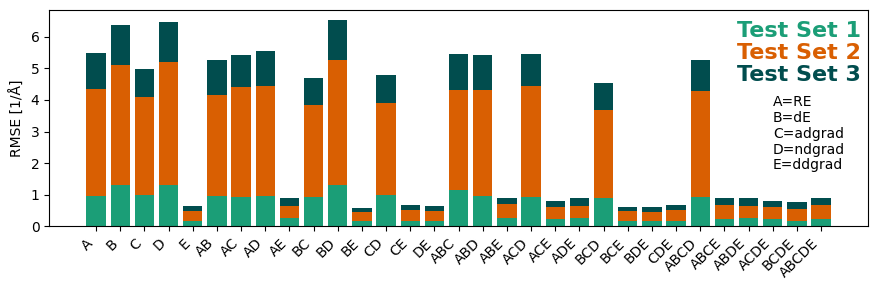

In [4]:
def encode_descriptor(row):
    encoding = {"RE": "A","dE": "B","adgrad": "C","ndgrad": "D","ddgrad": "E"}
    for key, value in encoding.items():
        row = row.replace(key, value)
        row = row.replace('_', '')
    return row

benchmark_data_casscf = pd.read_csv(f'data/benchmark_CASSCFlabeledSet.csv')
benchmark_data_casscf['Descriptor'] = benchmark_data_casscf['Descriptor'].apply(encode_descriptor)

fig, ax = plt.subplots(1, 1, figsize=(9, 3))
bottom = np.zeros(31)
colors = [cg, co, cdg]

i = 0
for d, d_count in benchmark_data_casscf.items():
    if 'RMSE' in d:
        p = ax.bar(benchmark_data_casscf['Descriptor'], d_count, 0.8, color=colors[i], label=d, bottom=bottom)
        bottom += d_count
        i += 1

ax.text(26.5, 6, r'Test Set 1', weight='bold', c=cg, fontsize=16)
ax.text(26.5, 5.3, r'Test Set 2', weight='bold', c=co, fontsize=16)
ax.text(26.5, 4.6, r'Test Set 3', weight='bold', c=cdg, fontsize=16)
ax.text(28, 3.8, r'A=RE', fontsize=10)
ax.text(28, 3.3, r'B=dE', fontsize=10)
ax.text(28, 2.8, r'C=adgrad', fontsize=10)
ax.text(28, 2.3, r'D=ndgrad', fontsize=10)
ax.text(28, 1.8, r'E=ddgrad', fontsize=10)
ax.set_ylabel('RMSE [1/Å]')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

save_fig('desc_rmse')
plt.show()


## 2. Phase-correcting algorithm

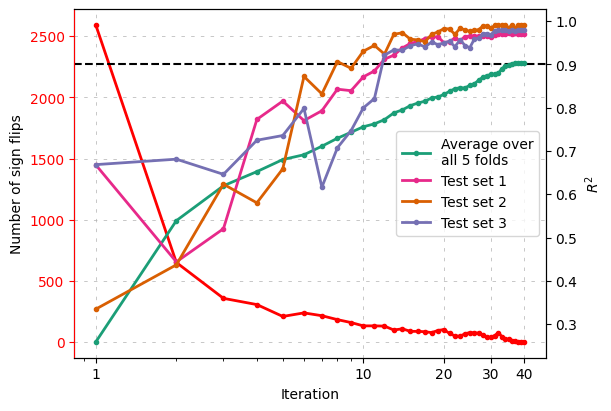

In [5]:
df = pd.read_csv('data/phasecorrection.csv')
df = df.groupby("iteration").agg({"flipped": "sum", "R2": "mean", "RMSE": "mean"}).reset_index()

df2 = pd.read_csv('data/phasecorrection_opthyper.csv')

fig, axs = plt.subplots(1, 1, figsize=(6, 4), layout="compressed")

axs.set_xlabel("Iteration")
axs.set_ylabel("Number of sign flips")
l1, = axs.plot(df['iteration'], df['flipped'], 'o-', lw=2, color="red", markersize=3)

axs2 = axs.twinx()
axs2.set_ylabel("$R^2$")
axs2.axhline(y=.9, c="black", linestyle='--')
l2, = axs2.plot(df['iteration'], df['R2'], 'o-', lw=2, label="Average over\nall 5 folds", c=cg, markersize=3) # Kfold test set:
l3, = axs2.plot(df2['iteration'], df2['R2_1'], 'o-', lw=2, label="Test set 1", c=cr, markersize=3) # Test set 1: 5000 randomly selected points
l4, = axs2.plot(df2['iteration'], df2['R2_2'], 'o-', lw=2, label="Test set 2", c=co, markersize=3) # Test set 2: 5000 points where Frobenius norm of NACs was larger than 5
l5, = axs2.plot(df2['iteration'], df2['R2_3'], 'o-', lw=2, label="Test set 3", c=cp, markersize=3) # Test set 3: 6010 points from first 10 trajectories

axs.set_xscale('log')
axs.set_xticks([1, 10, 20, 30, 40], ["1", "10", "20", "30", "40"])

lines = [l1, l2, l3, l4, l5]

axs.legend(lines, [l.get_label() for l in lines],loc="center right")
axs.grid(linestyle = '--', dashes=(5, 9), linewidth = 0.5)

axs.tick_params(axis='y', colors="red")
axs2.spines['left'].set_color("red")

save_fig('phase_correction', tight_layout=False)
plt.show()


## 3. Groups of hoppings
The margin of error is calculated as
\begin{equation*}
    \epsilon = 1.96\sqrt{\frac{p_i(1-p_i)}{N_{\text{traj}}}}
\end{equation*}

The mean torsional angle is calculated as 
\begin{equation*}
    \phi_{\text{C-CH}_2}=\frac{1}{4}\left( |\phi^{\text{cis}_1}_{\text{CC-CH}}| + |\phi^{\text{cis}_2}_{\text{CC-CH}}| + |180^\circ-\phi^{\text{trans}_1}_{\text{CC-CH}}| + |180^\circ-\phi^{\text{trans}_2}_{\text{CC-CH}}| \right)
\end{equation*}

In [ ]:
path = # path to the trajectories
output_name = 'hop_MSANIKRR.csv'
Ntraj = 1000

C_CH2_lens = []; C_CH2_dihedral_Cis1 = []; C_CH2_dihedral_Cis2 = []; C_CH2_dihedral_trans1 = []; C_CH2_dihedral_trans2 = []; hop_times = []
for j in range(Ntraj):
    traj = ml.data.molecular_trajectory()
    if Ntraj == 200: # CASSCF
        traj.load(f"{path}TRAJ{j+1}/traj.h5", format='h5md')
    if Ntraj == 1000: # MS-ANI + KRR
        traj.load(f"{path}traj_{j+1}.h5", format='h5md')
    hop_geoms = get_hop_geos(traj)
    for mol in hop_geoms:
        C_CH2_lens.append(mol.bond_length(0, 5))
        C_CH2_dihedral_Cis1.append(mol.dihedral_angle(2, 0, 5,10))
        C_CH2_dihedral_Cis2.append(mol.dihedral_angle(1, 0, 5,11))
        C_CH2_dihedral_trans1.append(mol.dihedral_angle(2, 0, 5,11))
        C_CH2_dihedral_trans2.append(mol.dihedral_angle(1, 0, 5,10))
        hop_times.append(mol.hoptime)

# Calculate hopping angle
hop_angle = []
for i in range(len(C_CH2_dihedral_Cis1)):
    hop_angle.append(0.25*(abs(C_CH2_dihedral_Cis1[i])+abs(C_CH2_dihedral_Cis2[i])+abs(180-abs(C_CH2_dihedral_trans1[i]))+abs(180-abs(C_CH2_dihedral_trans2[i]))))

with open(f'data/{output_name}', 'w', newline='') as ff:
    writer = csv.writer(ff)
    writer.writerow(['C_CH2_lens', 'hop_angle', 'hop_times'])
    writer.writerows(zip(C_CH2_lens, hop_angle, hop_times))

In [7]:
data = {
    'hop_CASSCF.csv': {},
    'hop_MSANIKRR.csv': {},
}

for output_name in data.keys():
    data[output_name] = pd.read_csv(f'data/{output_name}')
hops = {
    'hop_CASSCF.csv': [],
    'hop_MSANIKRR.csv': [],
}

# Count hopping occurence
for i, output_name in enumerate(data.keys()):
    hop_angle = data[output_name]['hop_angle'].tolist()
    C_CH2_lens = data[output_name]['C_CH2_lens'].tolist()
    # [Planar, Twisted-stretched, Twisted-shrunk, Total]
    hoppings = [0, 0, 0, len(hop_angle)]
    for i in range(len(hop_angle)):
        if hop_angle[i] < 30:
            hoppings[0] += 1
        else:
            if C_CH2_lens[i] > 1.55:
                hoppings[1] += 1
            else:
                hoppings[2] += 1
    hops[output_name] = hoppings

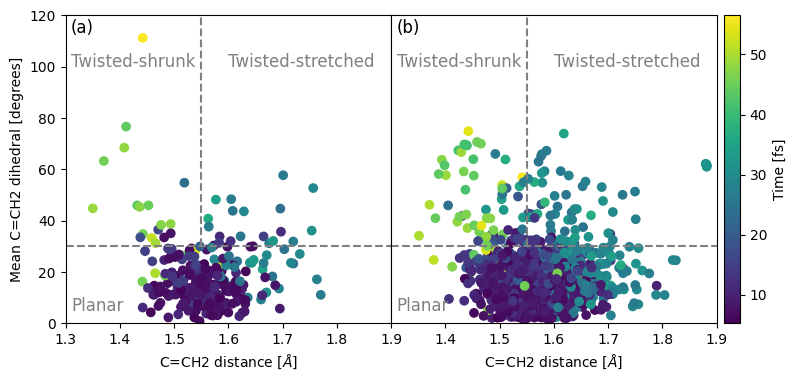

In [8]:
ylim = [0, 120]
xlim = [1.3, 1.9]
plot = ['(a)', '(b)']

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.subplots_adjust(wspace=0)
for i, output_name in enumerate(data.keys()):
    axs[i].axhline(y=30, color='grey', linestyle='--')
    axs[i].axvline(x=1.55, ymin=0.25, ymax=1, color='grey', linestyle='--')
    axs[i].text(1.31, 113, f'{plot[i]}', color='black', fontsize = 12)
    axs[i].text(1.31, 5, 'Planar', color='grey', fontsize = 12)
    axs[i].text(1.31, 100, 'Twisted-shrunk', color='grey', fontsize = 12)
    axs[i].text(1.6, 100, 'Twisted-stretched', color='grey', fontsize = 12)
    sc = axs[i].scatter(data[output_name]['C_CH2_lens'].tolist(), data[output_name]['hop_angle'].tolist(), c=data[output_name]['hop_times'].tolist())
    axs[i].set_xlabel("C=CH2 distance [$\AA$]")
    axs[i].set_ylabel("Mean C=CH2 dihedral [degrees]")
    axs[i].set_xlim(xlim)
    axs[i].set_ylim(ylim)
    #axs[i].set_title(f"{output_name}")
axs[1].set_xticks(axs[0].get_xticks()[1:])
axs[1].get_yaxis().set_visible(False)

cbar = fig.colorbar(sc, ax=axs, label='Time [fs]', pad=0.01)
save_fig('hopping_channels', tight_layout=False)
plt.show()

## 4. Populations

In [9]:
pop = {'data/pop_CASSCF_LZSH.txt': 623,
       'data/pop_MSANI_LZSH.txt': 1000,
       'data/pop_COLE_COLNAC_200.txt': 200,
       'data/pop_COLE_MLNAC_50.txt': 50, #'data/pop_COLE_MLNAC_200.txt': 200
       'data/pop_MLE_MLNAC_wOrigMSANI_KRRonMSANI.txt': 1000,
       'data/pop_MLE_MLNAC_wAugMSANI_KRRonMSANI.txt': 1000,
       }
pop_names = list(pop.keys())

data_pop = {'time': []}
for i, name in enumerate(pop.keys()):
    data_pop[name] = {'S0': [], 'S1': [], 'S0pe': [], 'S0me': [], 'S1pe': [], 'S1me': []}
    with open(name, 'r') as ff:
        j = 0
        for line in ff.read().splitlines():
            values = list(map(float, line.split()))
            if i == 0:
                data_pop['time'].append(values[0])
            data_pop[name]['S0'].append(values[1])
            data_pop[name]['S1'].append(values[2])
            err = mean_confidence_interval(data_pop[name]['S1'][j], pop[name])
            data_pop[name]['S1pe'].append(data_pop[name]['S1'][j]+err)
            data_pop[name]['S1me'].append(data_pop[name]['S1'][j]-err)
            err = mean_confidence_interval(data_pop[name]['S0'][j], pop[name])
            data_pop[name]['S0pe'].append(data_pop[name]['S0'][j]+err)
            data_pop[name]['S0me'].append(data_pop[name]['S0'][j]-err)
            j += 1

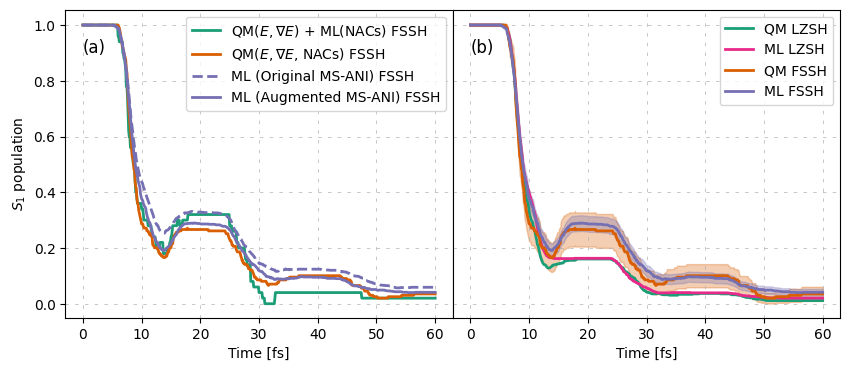

In [10]:
plot = ['(a)', '(b)']
state = 'S1'

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.subplots_adjust(wspace=0)

l0, = axs[0].plot(data_pop['time'], data_pop[pop_names[3]][state], c=cg, lw=2, label=r'QM($E,\nabla E$) + ML(NACs) FSSH') # CASSCF + ML NAC
l1, = axs[0].plot(data_pop['time'], data_pop[pop_names[2]][state], c=co, lw=2, label=r'QM($E,\nabla E$, NACs) FSSH') # CASSCF FSSH
l2, = axs[0].plot(data_pop['time'], data_pop[pop_names[4]][state], '--', c=cp, lw=2, label='ML (Original MS-ANI) FSSH') # original MS-ANI + KRR
l3, = axs[0].plot(data_pop['time'], data_pop[pop_names[5]][state], c=cp, lw=2, label='ML (Augmented MS-ANI) FSSH') # augmented MS-ANI + KRR

l4, = axs[1].plot(data_pop['time'], data_pop[pop_names[0]][state], c=cg, lw=2, label='QM LZSH') # CASSCF LZSH
l5, = axs[1].plot(data_pop['time'], data_pop[pop_names[1]][state], c=cr, lw=2, label='ML LZSH') # MS-ANI LZSH
l6, = axs[1].plot(data_pop['time'], data_pop[pop_names[2]][state], c=co, lw=2, label='QM FSSH') # CASSCF FSSH
axs[1].fill_between(data_pop['time'], data_pop[pop_names[2]][state+"pe"], data_pop[pop_names[2]][state+"me"], color=co, alpha=0.3)
l7, = axs[1].plot(data_pop['time'], data_pop[pop_names[5]][state], c=cp, lw=2, label='ML FSSH') # augmented MS-ANI + KRR
axs[1].fill_between(data_pop['time'], data_pop[pop_names[5]][state+"pe"], data_pop[pop_names[5]][state+"me"], color=cp, alpha=0.3)

axs[0].set_ylabel('$S_1$ population')
for i in range(2):
    axs[i].set_xlabel('Time [fs]')
    axs[i].text(0, 0.9, f'{plot[i]}', color='black', fontsize = 12)
    axs[i].grid(linestyle = '--', dashes=(5, 9), linewidth = 0.5)

lines0 = [l0, l1, l2, l3]
axs[0].legend(lines0, [l.get_label() for l in lines0],loc="upper right")
lines1 = [l4, l5, l6, l7]
axs[1].legend(lines1, [l.get_label() for l in lines1],loc="upper right")
axs[1].tick_params(axis='y', which='both', length=0)

save_fig('populations', tight_layout=False)
plt.show()


In [11]:
table = PrettyTable(["Observable", "MS-ANI LZSH", "CASSCF LZSH", "MS-ANI+KRR FSSH", "CASSCF FSSH"])
table.add_rows(
    [ 
        ["Population at 20 fs (%)", f"{100*data_pop['data/pop_MSANI_LZSH.txt']['S1'][201]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_MSANI_LZSH.txt']['S1'][201], pop['data/pop_MSANI_LZSH.txt']):.1f}", f"{100*data_pop['data/pop_CASSCF_LZSH.txt']['S1'][201]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_CASSCF_LZSH.txt']['S1'][201], pop['data/pop_CASSCF_LZSH.txt']):.1f}", f"{100*data_pop['data/pop_MLE_MLNAC_wAugMSANI_KRRonMSANI.txt']['S1'][201]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_MLE_MLNAC_wAugMSANI_KRRonMSANI.txt']['S1'][201], pop['data/pop_MLE_MLNAC_wAugMSANI_KRRonMSANI.txt']):.1f}", f"{100*data_pop['data/pop_COLE_COLNAC_200.txt']['S1'][201]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_COLE_COLNAC_200.txt']['S1'][201], pop['data/pop_COLE_COLNAC_200.txt']):.1f}"],
        ["Population at 40 fs (%)", f"{100*data_pop['data/pop_MSANI_LZSH.txt']['S1'][401]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_MSANI_LZSH.txt']['S1'][401], pop['data/pop_MSANI_LZSH.txt']):.1f}", f"{100*data_pop['data/pop_CASSCF_LZSH.txt']['S1'][401]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_CASSCF_LZSH.txt']['S1'][401], pop['data/pop_CASSCF_LZSH.txt']):.1f}", f"{100*data_pop['data/pop_MLE_MLNAC_wAugMSANI_KRRonMSANI.txt']['S1'][401]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_MLE_MLNAC_wAugMSANI_KRRonMSANI.txt']['S1'][401], pop['data/pop_MLE_MLNAC_wAugMSANI_KRRonMSANI.txt']):.1f}", f"{100*data_pop['data/pop_COLE_COLNAC_200.txt']['S1'][401]:.1f} +- {100*mean_confidence_interval(data_pop['data/pop_COLE_COLNAC_200.txt']['S1'][401], pop['data/pop_COLE_COLNAC_200.txt']):.1f}"],
        ["Planar (%)", "93.8 +- 1.5", "94.0 +- 1.8", f"{100*hops['hop_MSANIKRR.csv'][0]/hops['hop_MSANIKRR.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_MSANIKRR.csv'][0]/hops['hop_MSANIKRR.csv'][3], hops['hop_MSANIKRR.csv'][3]):.1f}", f"{100*hops['hop_CASSCF.csv'][0]/hops['hop_CASSCF.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_CASSCF.csv'][0]/hops['hop_CASSCF.csv'][3], hops['hop_CASSCF.csv'][3]):.1f}"],
        ["Twisted-stretched (%)", "4.1 +- 1.2", "3.7 +- 1.8", f"{100*hops['hop_MSANIKRR.csv'][1]/hops['hop_MSANIKRR.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_MSANIKRR.csv'][1]/hops['hop_MSANIKRR.csv'][3], hops['hop_MSANIKRR.csv'][3]):.1f}", f"{100*hops['hop_CASSCF.csv'][1]/hops['hop_CASSCF.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_CASSCF.csv'][1]/hops['hop_CASSCF.csv'][3], hops['hop_CASSCF.csv'][3]):.1f}"],
        ["Twisted-shrunk (%)", "2.2 +- 0.9", "2.3 +- 1.2", f"{100*hops['hop_MSANIKRR.csv'][2]/hops['hop_MSANIKRR.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_MSANIKRR.csv'][2]/hops['hop_MSANIKRR.csv'][3], hops['hop_MSANIKRR.csv'][3]):.1f}", f"{100*hops['hop_CASSCF.csv'][2]/hops['hop_CASSCF.csv'][3]:.1f} +- {100*mean_confidence_interval(hops['hop_CASSCF.csv'][2]/hops['hop_CASSCF.csv'][3], hops['hop_CASSCF.csv'][3]):.1f}"],
    ]
)   

print(table)


+-------------------------+-------------+-------------+-----------------+-------------+
|        Observable       | MS-ANI LZSH | CASSCF LZSH | MS-ANI+KRR FSSH | CASSCF FSSH |
+-------------------------+-------------+-------------+-----------------+-------------+
| Population at 20 fs (%) | 16.3 +- 2.3 | 16.1 +- 2.9 |   28.6 +- 2.8   | 26.6 +- 6.1 |
| Population at 40 fs (%) |  3.9 +- 1.2 |  3.7 +- 1.5 |    9.5 +- 1.8   | 10.1 +- 4.2 |
|        Planar (%)       | 93.8 +- 1.5 | 94.0 +- 1.8 |   89.9 +- 1.6   | 85.2 +- 4.2 |
|  Twisted-stretched (%)  |  4.1 +- 1.2 |  3.7 +- 1.8 |    5.3 +- 1.2   |  7.7 +- 3.2 |
|    Twisted-shrunk (%)   |  2.2 +- 0.9 |  2.3 +- 1.2 |    4.8 +- 1.1   |  7.0 +- 3.0 |
+-------------------------+-------------+-------------+-----------------+-------------+


# 5. Tiny plots for diagram

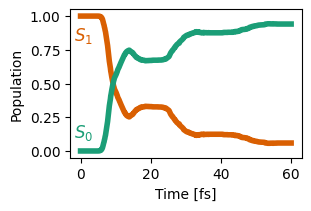

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2), layout="compressed")

ax.set_xlabel('Time [fs]')
ax.set_ylabel('Population')
ax.plot(data_pop['time'], data_pop[pop_names[4]]['S1'], c=co, lw=4)
ax.plot(data_pop['time'], data_pop[pop_names[4]]['S0'], c=cg, lw=4)
ax.text(-2, 0.1, r'$S_0$', weight='bold', c=cg, fontsize=12)
ax.text(-2, 0.82, r'$S_1$', weight='bold', c=co, fontsize=12)

save_fig('pnew', tight_layout=False)
plt.show()

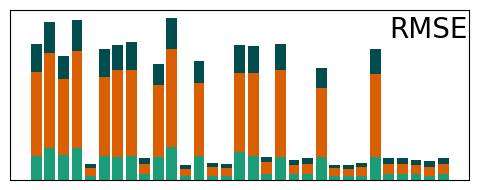

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))

bottom = np.zeros(31)
colors = [cg, co, cdg]

i = 0
for d, d_count in benchmark_data_casscf.items():
    if 'RMSE' in d:
        p = ax.bar(benchmark_data_casscf['Descriptor'], d_count, 0.8, color=colors[i], label=d, bottom=bottom)
        bottom += d_count
        i += 1
ax.text(26, 5.7, r'RMSE', fontsize=20)
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
save_fig('rmse')
plt.show()

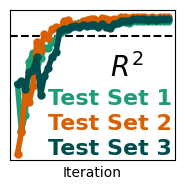

In [14]:
df2 = pd.read_csv('data/phasecorrection_opthyper.csv')

fig, ax = plt.subplots(1, 1, figsize=(2, 2), layout="compressed")

ax.set_xlabel("Iteration")

ax.axhline(y=.9, c="black", linestyle='--')
l3, = ax.plot(df2['iteration'], df2['R2_1'], 'o-', lw=4, label="Test set 1", c=cg, markersize=5)
l4, = ax.plot(df2['iteration'], df2['R2_2'], 'o-', lw=4, label="Test set 2", c=co, markersize=5)
l5, = ax.plot(df2['iteration'], df2['R2_3'], 'o-', lw=4, label="Test set 3", c=cdg, markersize=5)
ax.text(25, 0.7, '$R^2$', fontsize=20)
ax.text(9, 0.57, r'Test Set 1', weight='bold', c=cg, fontsize=16)
ax.text(9, 0.45, r'Test Set 2', weight='bold', c=co, fontsize=16)
ax.text(9, 0.33, r'Test Set 3', weight='bold', c=cdg, fontsize=16)

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', left=False, labelleft=False)

save_fig('r2')
plt.show()

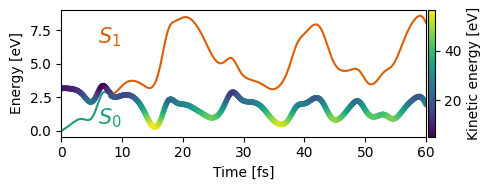

In [ ]:
data_dir = # path to traj in h5md format
traj = ml.data.molecular_trajectory()
traj.load(filename=f"{data_dir}", format='h5md')

time = list(np.arange(0.0, 60 + 0.1, 0.1))
en_0 = np.array([istep.molecule.electronic_states[0].energy for istep in traj.steps])
en_1 = np.array([istep.molecule.electronic_states[1].energy for istep in traj.steps])
en_current = np.array([istep.molecule.electronic_states[int(istep.current_state)].energy for istep in traj.steps])
en_kin = np.array([istep.molecule.kinetic_energy for istep in traj.steps])

fig1, ax1 = plt.subplots(figsize=(5,2))

ax1.plot(time, 27.2107*(en_0-min(en_0)), c=cg, label="$S_0$")
ax1.plot(time, 27.2107*(en_1-min(en_0)), c=co, label="$S_1$")
cmap = plt.cm.viridis
ax1.scatter(time, 27.2107*(en_current-min(en_0)), c=27.2107*en_kin, cmap=cmap, s=9, label="Current", zorder=2)

cbar = plt.colorbar(sc, ax=ax1, pad=0.005)
cbar.set_label("Kinetic energy [eV]")
ax1.set_xlabel("Time [fs]")
ax1.set_ylabel("Energy [eV]")
plt.text(6, 0.5, r'$S_0$', c=cg, fontsize=15)
plt.text(6, 6.5, r'$S_1$', c=co, fontsize=15)

ax1.set_xlim([0, 60])

plt.tight_layout()
#save_fig('traj')
plt.show()